In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
from utils import format_node_names

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('./system_analytics_2024/slurm_data')
folder_path_saving_results = Path('./results')



df = pd.read_parquet(folder_path_slurm_data / 'sinfo_cleaned.parquet.gzip')
df.sample(n=10)

node                time      state node_type time_30min_interval  \
325   tcn515 2024-11-06 10:04:30  allocated       tcn 2024-11-06 10:00:00   
299  tcn1047 2024-11-07 04:25:05       idle       tcn 2024-11-07 04:00:00   
336   tcn384 2024-11-10 15:14:15  allocated       tcn 2024-11-10 15:00:00   
193   tcn969 2024-11-09 15:54:54       idle       tcn 2024-11-09 15:30:00   
220  tcn1016 2024-11-10 02:45:55       idle       tcn 2024-11-10 02:30:00   
329   tcn375 2024-11-09 05:21:57  allocated       tcn 2024-11-09 05:00:00   
6     tcn603 2024-11-10 06:08:31       idle       tcn 2024-11-10 06:00:00   
249   tcn346 2024-11-05 02:14:39  allocated       tcn 2024-11-05 02:00:00   
39    tcn600 2024-11-09 11:10:36  allocated       tcn 2024-11-09 11:00:00   
100   tcn657 2024-11-08 04:41:23  allocated       tcn 2024-11-08 04:30:00   

    time_1hour_interval time_3hour_interval time_6hour_interval  \
325 2024-11-06 10:00:00 2024-11-06 09:00:00 2024-11-06 06:00:00   
299 2024-11-07 04:00:00 2024-11-07 03:00:00 2024-11-07 00:00:00   
336 2024-11-10 15:00:00 2024-11-10 15:00:00 2024-11-10 12:00:00   
193 2024-11-09 15:00:00 2024-11-09 15:00:00 2024-11-09 12:00:00   
220 2024-11-10 02:00:00 2024-11-10 00:00:00 2024-11-10 00:00:00   
329 2024-11-09 05:00:00 2024-11-09 03:00:00 2024-11-09 00:00:00   
6   2024-11-10 06:00:00 2024-11-10 06:00:00 2024-11-10 06:00:00   
249 2024-11-05 02:00:00 2024-11-05 00:00:00 2024-11-05 00:00:00   
39  2024-11-09 11:00:00 2024-11-09 09:00:00 2024-11-09 06:00:00   
100 2024-11-08 04:00:00 2024-11-08 03:00:00 2024-11-08 00:00:00   

    time_day_interval  
325        2024-11-06  
299        2024-11-07  
336        2024-11-10  
193        2024-11-09  
220        2024-11-10  
329        2024-11-09  
6          2024-11-10  
249        2024-11-05  
39         2024-11-09  
100        2024-11-08

In [3]:
time_col = 'time_3hour_interval'
df_temp = df.groupby(['node',time_col], as_index=False)['state'].value_counts(normalize=True)
df_temp.sort_values(['node', time_col], inplace=True)
N = 7 * 10**3
display(df_temp.iloc[N: N + 10, :])
node_name = df_temp.iloc[N+5, 0]

node time_3hour_interval state  proportion
7000  fcn97 2024-11-06 21:00:00  idle         1.0
7001  fcn97 2024-11-07 00:00:00  idle         1.0
7002  fcn97 2024-11-07 03:00:00  idle         1.0
7003  fcn97 2024-11-07 06:00:00  idle         1.0
7004  fcn97 2024-11-07 09:00:00  idle         1.0
7005  fcn97 2024-11-07 12:00:00  idle         1.0
7006  fcn97 2024-11-07 15:00:00  idle         1.0
7007  fcn97 2024-11-07 18:00:00  idle         1.0
7008  fcn97 2024-11-07 21:00:00  idle         1.0
7009  fcn97 2024-11-08 00:00:00  idle         1.0

In [4]:
""" 
We distinguish between two cases: idle and not idle. 
For the not idle part we add the proportion of the time in
the time interval where the state!= idle. 
"""

df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'proportion':'idle'}, inplace=True)
# get the not idle states and add their shares together and count it as not_idle!
df_not_idle = df_temp[(df_temp['state']!='idle')].copy()
df_not_idle = df_not_idle.groupby(['node', time_col], as_index=False)['proportion'].sum().copy()
df_not_idle.rename(columns={'proportion':'not_idle'}, inplace=True)
# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_not_idle, how='outer', on=['node', time_col])
df_stat.fillna(value=0, inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)

display(df_idle[df_idle.node == node_name].head(),
        df_not_idle[df_not_idle.node == node_name].head(n=20), df_stat[df_stat.node == node_name].head(n=20),) 

node time_3hour_interval  idle
6982  fcn97 2024-11-04 15:00:00   1.0
6983  fcn97 2024-11-04 18:00:00   1.0
6984  fcn97 2024-11-04 21:00:00   1.0
6985  fcn97 2024-11-05 00:00:00   1.0
6986  fcn97 2024-11-05 03:00:00   1.0

Empty DataFrame
Columns: [node, time_3hour_interval, not_idle]
Index: []

node time_3hour_interval  idle  not_idle
5733  fcn97 2024-11-04 15:00:00   1.0       0.0
5734  fcn97 2024-11-04 18:00:00   1.0       0.0
5735  fcn97 2024-11-04 21:00:00   1.0       0.0
5736  fcn97 2024-11-05 00:00:00   1.0       0.0
5737  fcn97 2024-11-05 03:00:00   1.0       0.0
5738  fcn97 2024-11-05 06:00:00   1.0       0.0
5739  fcn97 2024-11-05 09:00:00   1.0       0.0
5740  fcn97 2024-11-05 12:00:00   1.0       0.0
5741  fcn97 2024-11-05 15:00:00   1.0       0.0
5742  fcn97 2024-11-05 18:00:00   1.0       0.0
5743  fcn97 2024-11-05 21:00:00   1.0       0.0
5744  fcn97 2024-11-06 00:00:00   1.0       0.0
5745  fcn97 2024-11-06 03:00:00   1.0       0.0
5746  fcn97 2024-11-06 06:00:00   1.0       0.0
5747  fcn97 2024-11-06 09:00:00   1.0       0.0
5748  fcn97 2024-11-06 12:00:00   1.0       0.0
5749  fcn97 2024-11-06 15:00:00   1.0       0.0
5750  fcn97 2024-11-06 18:00:00   1.0       0.0
5751  fcn97 2024-11-06 21:00:00   1.0       0.0
5752  fcn97 2024-11-07 00:00:00   1.0       0.0

In [5]:
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
display(df_stat_pivot.head())

node                 fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_3hour_interval                                                         
2024-11-04 15:00      0.0  0.1717     1.0     1.0     1.0     1.0     1.0   
2024-11-04 18:00      0.0  0.0000     1.0     1.0     1.0     1.0     1.0   
2024-11-04 21:00      0.0  0.0000     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00      0.0  0.0458     1.0     1.0     1.0     1.0     1.0   
2024-11-05 03:00      0.0  1.0000     1.0     1.0     1.0     1.0     1.0   

node                 fcn105  fcn106  fcn107  fcn108  fcn109  fcn11  fcn110  \
time_3hour_interval                                                          
2024-11-04 15:00        1.0     1.0     1.0     1.0     1.0    0.0     1.0   
2024-11-04 18:00        1.0     1.0     1.0     1.0     1.0    0.0     1.0   
2024-11-04 21:00        1.0     1.0     1.0     1.0     1.0    0.0     1.0   
2024-11-05 00:00        1.0     1.0     1.0     1.0     1.0    0.0     1.0   
2024-11-05 03:00        1.0     1.0     1.0     1.0     1.0    0.0     1.0   

node                 fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_3hour_interval                                                           
2024-11-04 15:00        1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-04 18:00        1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-04 21:00        1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00        1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 03:00        1.0     1.0     1.0     1.0     1.0     1.0     1.0   

node                 fcn118  fcn119   fcn12  fcn120   fcn13  fcn14   fcn15  \
time_3hour_interval                                                          
2024-11-04 15:00        1.0     1.0  0.1717     1.0  0.1717    0.0  0.1717   
2024-11-04 18:00        1.0     1.0  0.0000     1.0  0.0000    0.0  0.0000   
2024-11-04 21:00        1.0     1.0  0.0000     1.0  0.0000    0.0  0.0000   
2024-11-05 00:00        1.0     1.0  0.0000     1.0  0.0000    0.0  0.0000   
2024-11-05 03:00        1.0     1.0  0.0000     1.0  0.9246    0.0  0.8766   

node                  fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_3hour_interval                                                           
2024-11-04 15:00     0.1717  0.1717  0.1717  1.0000  0.0000  0.1717  0.1717   
2024-11-04 18:00     0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000   
2024-11-04 21:00     0.0032  0.0000  0.0000  0.9841  0.0032  0.0000  0.0000   
2024-11-05 00:00     0.0552  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000   
2024-11-05 03:00     1.0000  0.8758  0.9246  1.0000  0.0000  0.9246  0.9246   

node                  fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_3hour_interval                                                           
2024-11-04 15:00     0.1717  0.1717  0.1717  1.0000  0.1717  0.1717  0.1717   
2024-11-04 18:00     0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000   
2024-11-04 21:00     0.0000  0.0000  0.0000  0.9841  0.0000  0.0000  0.0000   
2024-11-05 00:00     0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000   
2024-11-05 03:00     0.9246  0.9246  0.9246  1.0000  0.0000  0.0000  0.9246   

node                  fcn29  fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_3hour_interval                                                         
2024-11-04 15:00     0.1717   0.0  0.1717  0.1717  0.1717  0.1717  0.1717   
2024-11-04 18:00     0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-04 21:00     0.0032   0.0  0.0000  0.0000  0.0032  0.0000  0.0000   
2024-11-05 00:00     0.0000   0.0  0.0000  0.0000  0.0000  0.0000  0.0000   
2024-11-05 03:00     0.0000   0.0  0.9246  0.5518  0.0000  0.0000  0.9246   

node                  fcn35   fcn36  fcn37   fcn38   fcn39  fcn4   fcn40  \
time_3hour_interval                                                        
2024-11-04 1

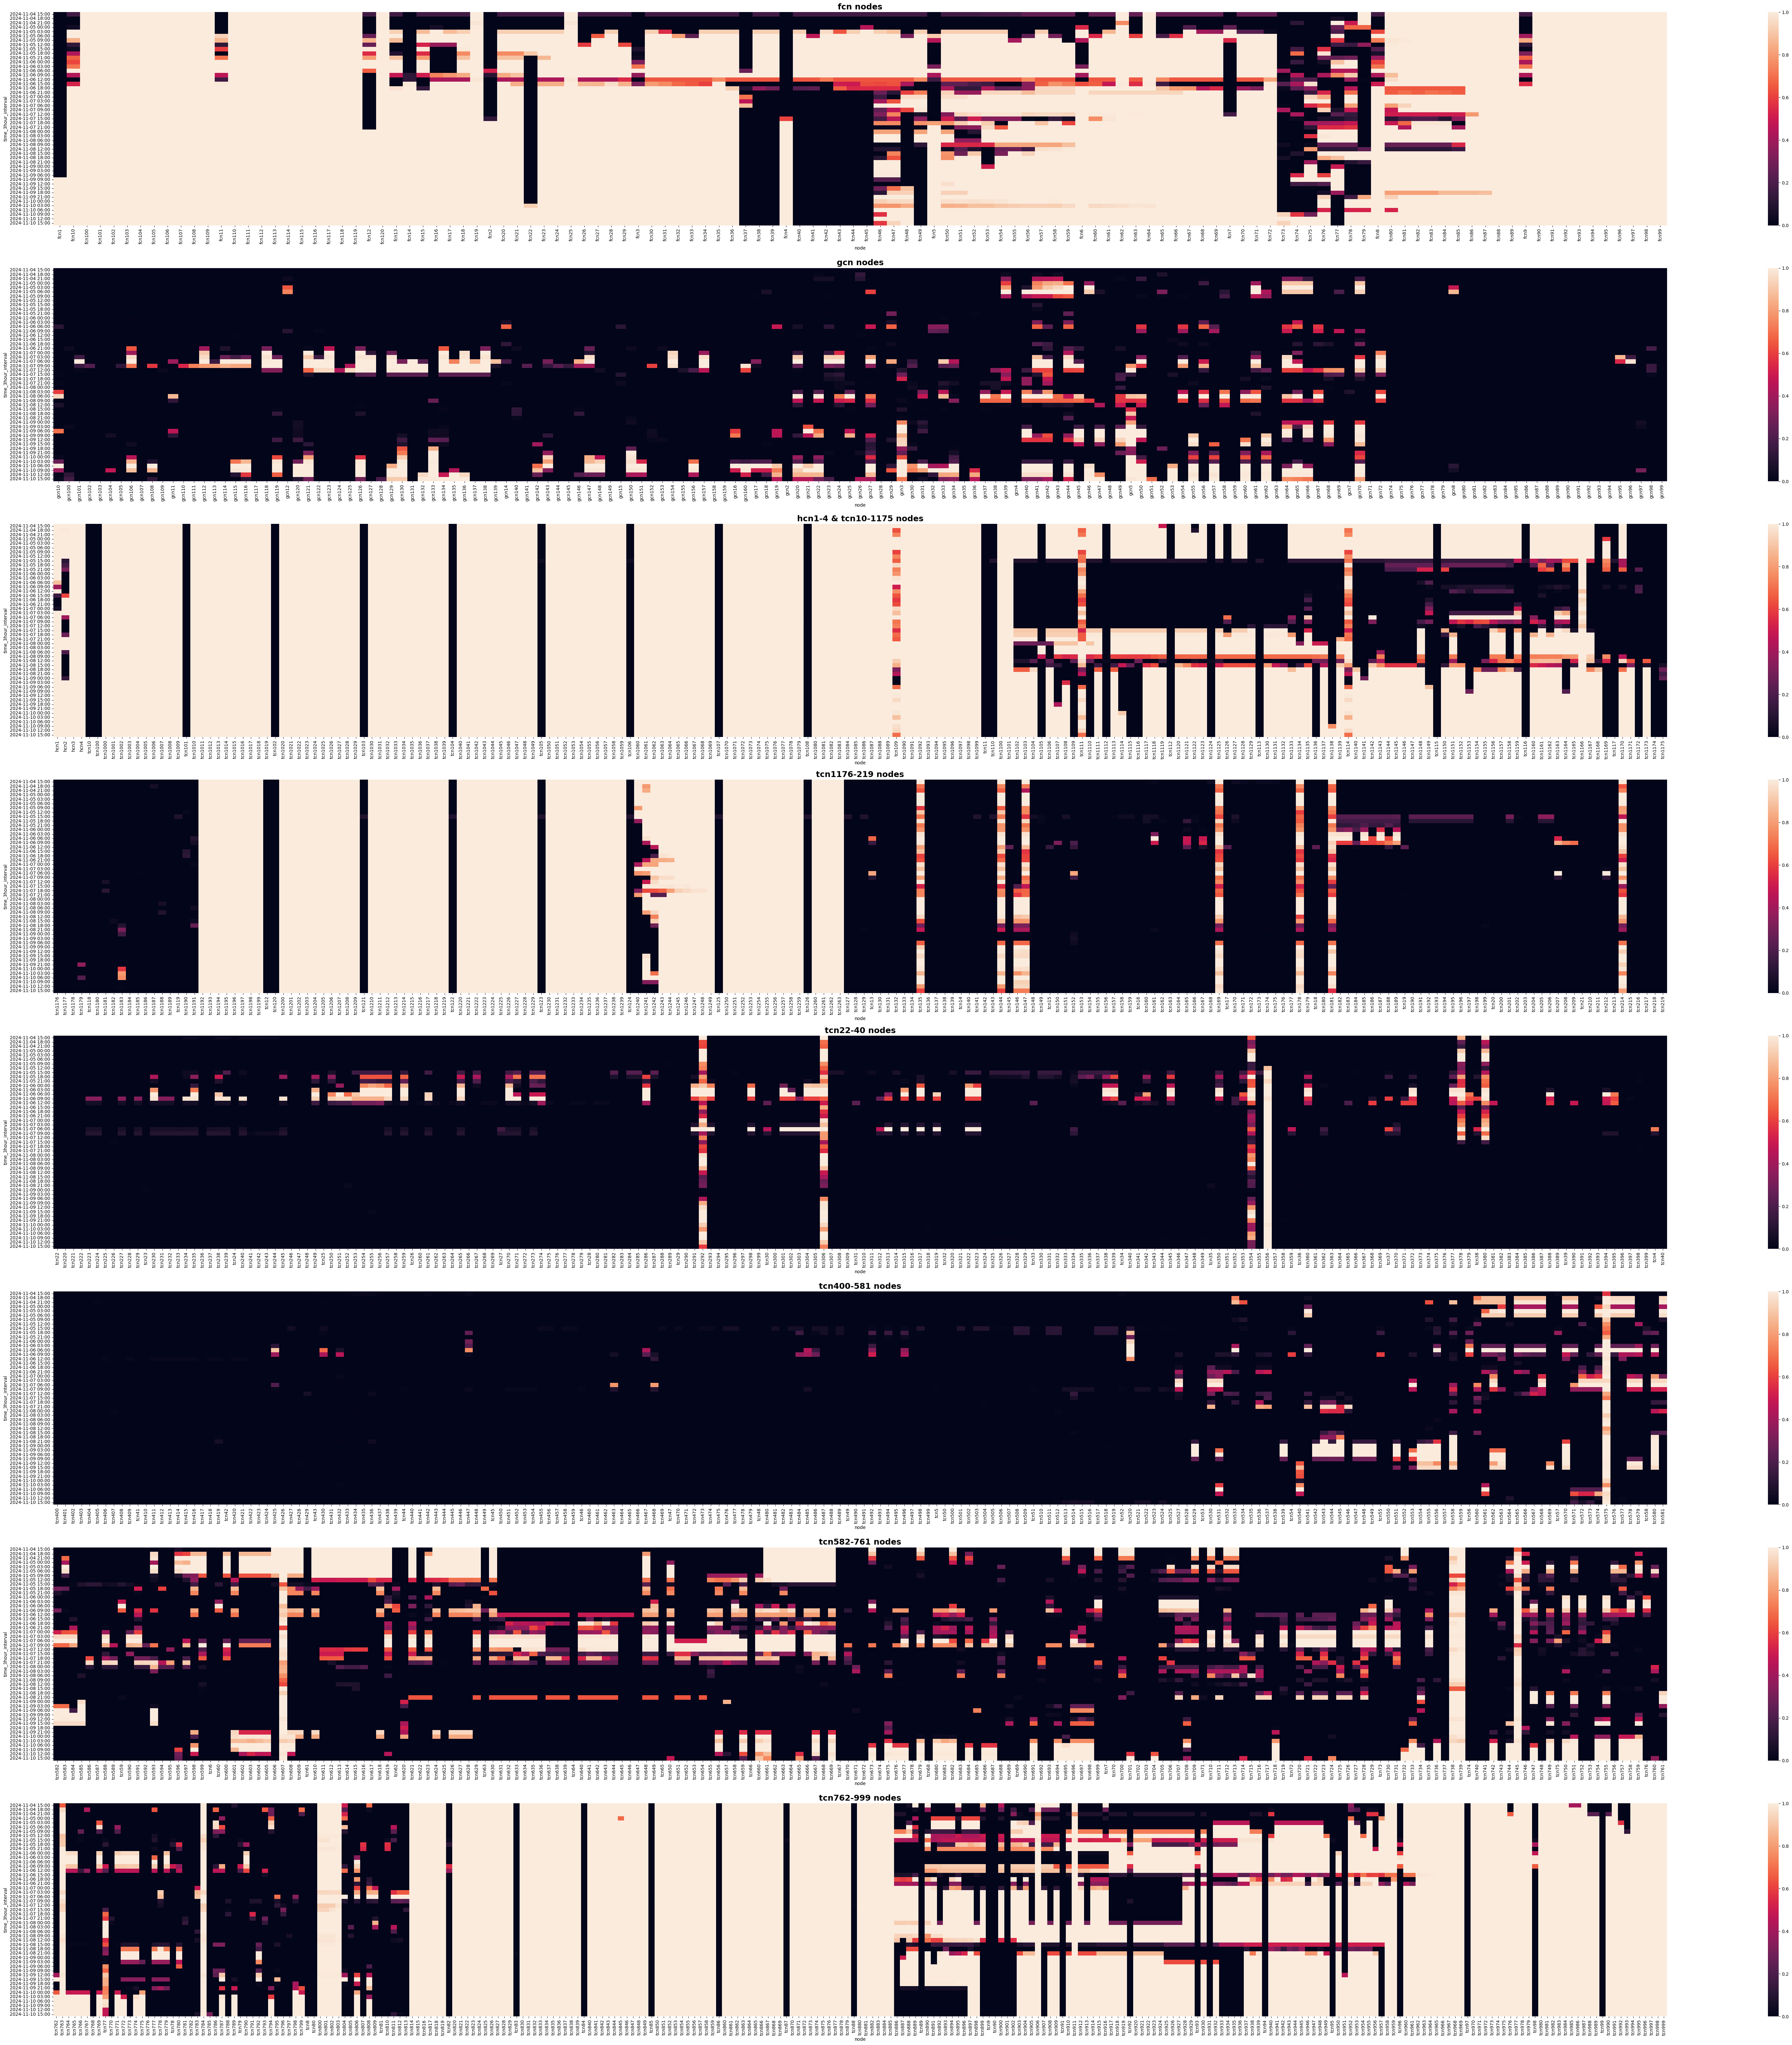

In [6]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))
# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]
titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]


# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_stat_pivot.iloc[:, start:end], ax=ax[i], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot


fig.savefig(folder_path_saving_results/"nodes_idle_partition.pdf", transparent=True)
fig.savefig(folder_path_saving_results/'nodes_idle_partition.png', dpi=200)
plt.show()

# move the figures for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .

In [7]:
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()
df_sorted_nodes.head()

node                 tcn99  tcn299  tcn97  tcn29  tcn288  tcn28  tcn690  \
time_3hour_interval                                                       
2024-11-04 15:00       0.0     0.0    0.0    0.0     0.0    0.0     0.0   
2024-11-04 18:00       0.0     0.0    0.0    0.0     0.0    0.0     0.0   
2024-11-04 21:00       0.0     0.0    0.0    0.0     0.0    0.0     0.0   
2024-11-05 00:00       0.0     0.0    0.0    0.0     0.0    0.0     0.0   
2024-11-05 03:00       0.0     0.0    0.0    0.0     0.0    0.0     0.0   

node                 gcn103  tcn703  tcn702  tcn277  tcn346  tcn351  tcn1189  \
time_3hour_interval                                                            
2024-11-04 15:00        0.0     0.0     0.0     0.0     0.0     0.0      0.0   
2024-11-04 18:00        0.0     0.0     0.0     0.0     0.0     0.0      0.0   
2024-11-04 21:00        0.0     0.0     0.0     0.0     0.0     0.0      0.0   
2024-11-05 00:00        0.0     0.0     0.0     0.0     0.0     0.0      0.0   
2024-11-05 03:00        0.0     0.0     0.0     0.0     0.0     0.0      0.0   

node                 gcn107  tcn678  tcn357  tcn333  tcn120  tcn12  tcn510  \
time_3hour_interval                                                          
2024-11-04 15:00        0.0     0.0     0.0     0.0     0.0    0.0     0.0   
2024-11-04 18:00        0.0     0.0     0.0     0.0     0.0    0.0     0.0   
2024-11-04 21:00        0.0     0.0     0.0     0.0     0.0    0.0     0.0   
2024-11-05 00:00        0.0     0.0     0.0     0.0     0.0    0.0     0.0   
2024-11-05 03:00        0.0     0.0     0.0     0.0     0.0    0.0     0.0   

node                 gcn93  gcn91  gcn92  gcn86  gcn87  gcn88  gcn89  gcn90  \
time_3hour_interval                                                           
2024-11-04 15:00       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-04 18:00       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-04 21:00       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 03:00       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                 tcn385  tcn374  tcn373  tcn499  tcn493  tcn495  tcn497  \
time_3hour_interval                                                           
2024-11-04 15:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 21:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 03:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node                 tcn502  tcn103  tcn490  tcn491  tcn500  tcn101  tcn100  \
time_3hour_interval                                                           
2024-11-04 15:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 21:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 03:00        0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node                 gcn94  tcn102  gcn2  gcn159  gcn48  tcn400  tcn401  \
time_3hour_interval                                                       
2024-11-04 15:00       0.0     0.0   0.0     0.0    0.0     0.0     0.0   
2024-11-04 18:00       0.0     0.0   0.0     0.0    0.0     0.0     0.0   
2024-11-04 21:00       0.0     0.0   0.0     0.0    0.0     0.0     0.0   
2024-11-05 00:00       0.0     0.0   0.0     0.0    0.0     0.0     0.0   
2024-11-05 03:00       0.0     0.0   0.0     0.0    0.0     0.0     0.0   

node                 tcn408  tcn410  tcn1176  tcn1174  tcn647  gcn149  tcn203  \
time_3hour_interval                                                             
2024-11-04 15:00

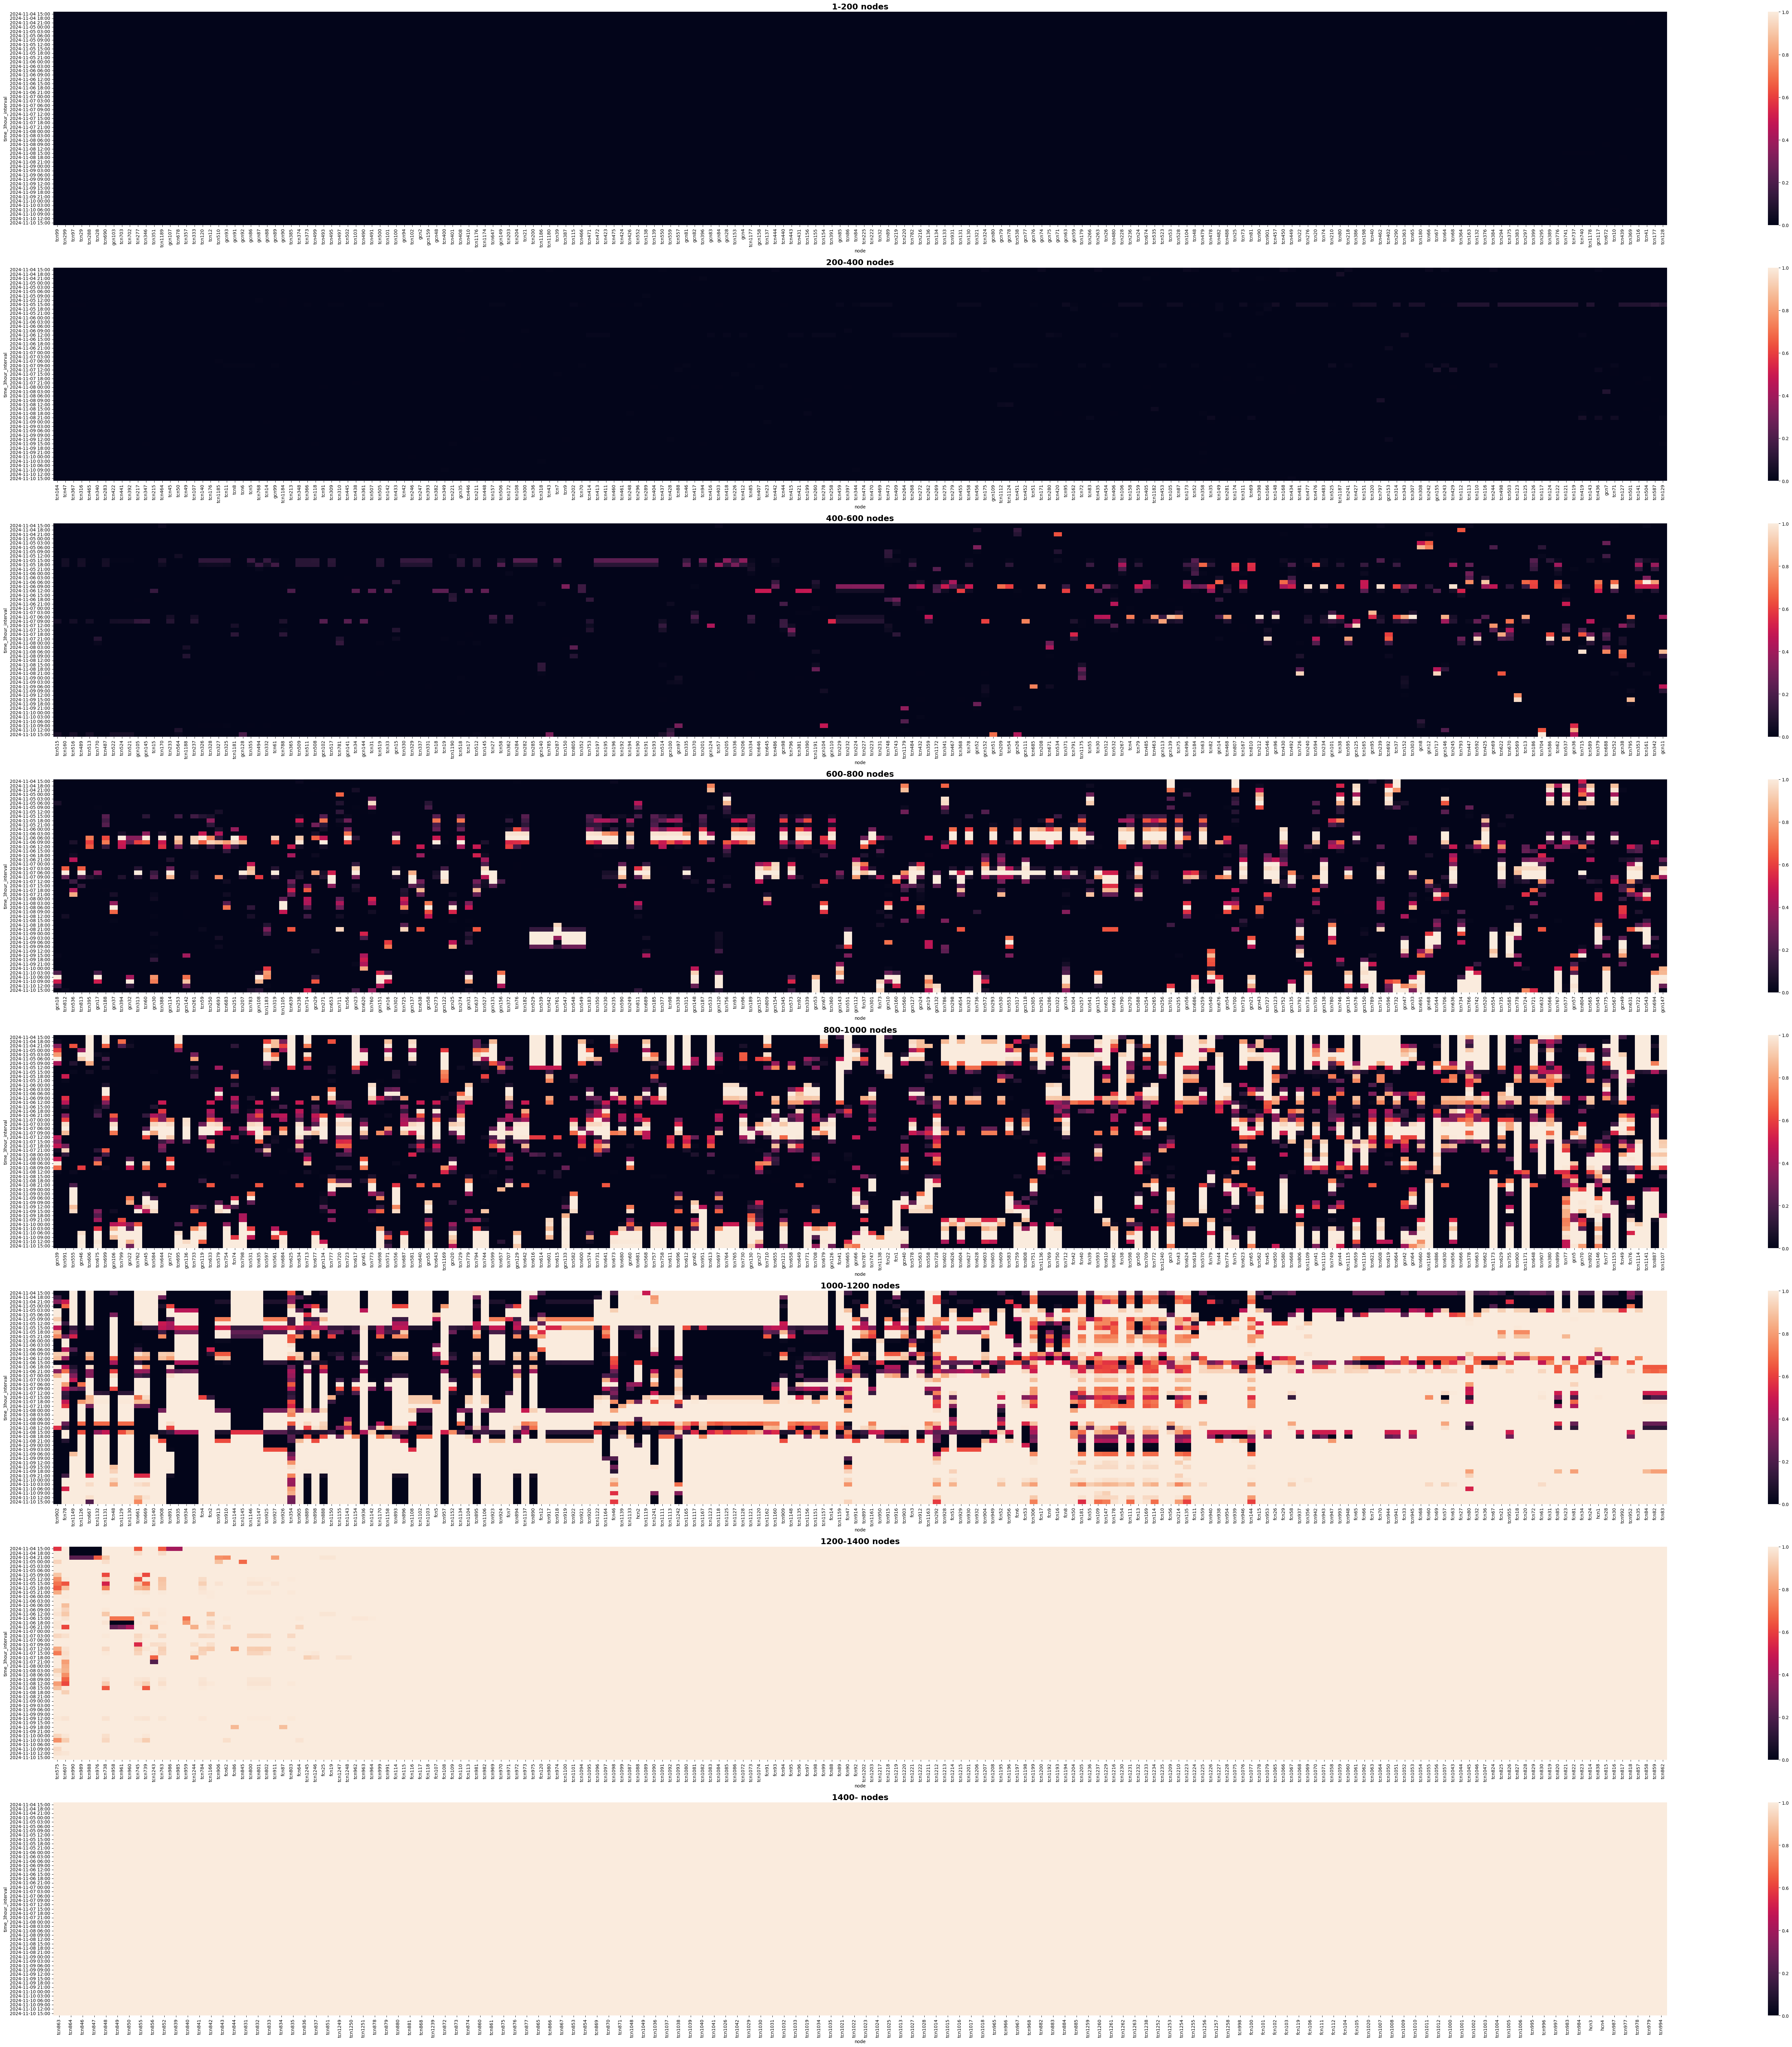

In [8]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_sorted_nodes.iloc[:, start:end], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                ax=ax[i], cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot
    # Set x and y tick parameters to bold font
    # ax[i].tick_params(axis='x', labelsize=12)  # Bold x-tick labels
    # ax[i].tick_params(axis='y', labelsize=12)   # Bold y-tick labels

    # ax[i].xaxis.set_tick_params(labelsize=12)
    # ax[i].yaxis.set_tick_params(labelsize=12)
fig.savefig(folder_path_saving_results/"nodes_idle_ranked.pdf", transparent=True)
fig.savefig(folder_path_saving_results/'nodes_idle_ranked.png', dpi=200)
plt.show()